<a href="https://colab.research.google.com/github/saidfreeds13/cultural_vibrancy/blob/main/Diversity_indexes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install osmnx mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 10.6 MB/s eta 0:00:00


In [ ]:
!pip install "h3~=3.7"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.8 MB/s eta 0:00:00


In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.5 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import folium
import mapclassify
import osmnx

In [ ]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import mapping, Polygon
from h3.api.numpy_int import polyfill, h3_to_geo_boundary
import matplotlib.pyplot as plt
import math
import seaborn as sns
import contextily as cx
import matplotlib

# DATA PROCESSING

In [ ]:
loc = gpd.read_file("/content/arts_petr.gpkg")

In [ ]:
loc = loc.to_crs(32636)
print(loc.crs)

EPSG:32636


In [ ]:
spb1 = osmnx.geocoder.geocode_to_gdf("Петроградская")

In [ ]:
spb1 = spb1.to_crs(epsg=32636)

In [ ]:
loc_inside = gpd.sjoin(loc, spb1, predicate="within")

In [ ]:
map = loc_inside.explore(tiles="CartoDB positron")
loc_inside.explore(
    m=map,
    color="purple")

# Diversity indexes

##Richness

In [ ]:
def richness(group):
    return group['Рубрики'].nunique()

## Simpson Diversity

In [ ]:
def simpson_diversity(group):
    proportions = group['Рубрики'].value_counts(normalize=True)
    return 1 - np.sum(proportions ** 2)

## Berger Parker

In [ ]:
def berger_parker(group):
    proportions = group['Рубрики'].value_counts(normalize=True)
    # Berger-Parker = max proportion
    return proportions.max()

## Shannon weiner

In [ ]:
def shannon_wiener_diversity(group):
    proportions = group['Рубрики'].value_counts(normalize=True)
    proportions = proportions[proportions > 0]
    return -np.sum(proportions * np.log(proportions))

## shannon_wiener_equity

In [ ]:
def shannon_wiener_equity(group):
    proportions = group['Рубрики'].value_counts(normalize=True)
    shannon_entropy = -np.sum(proportions * np.log(proportions))
    richness = len(proportions)
    if richness > 1:
        equity = shannon_entropy / np.log(richness)
    else:
        equity = 1.0
    return equity


# Grid creation

In [ ]:
!pip install "h3~=3.7"

In [ ]:
import h3
print(h3.__version__)

3.7.7


Number of hexagons covering Петроградская: 10


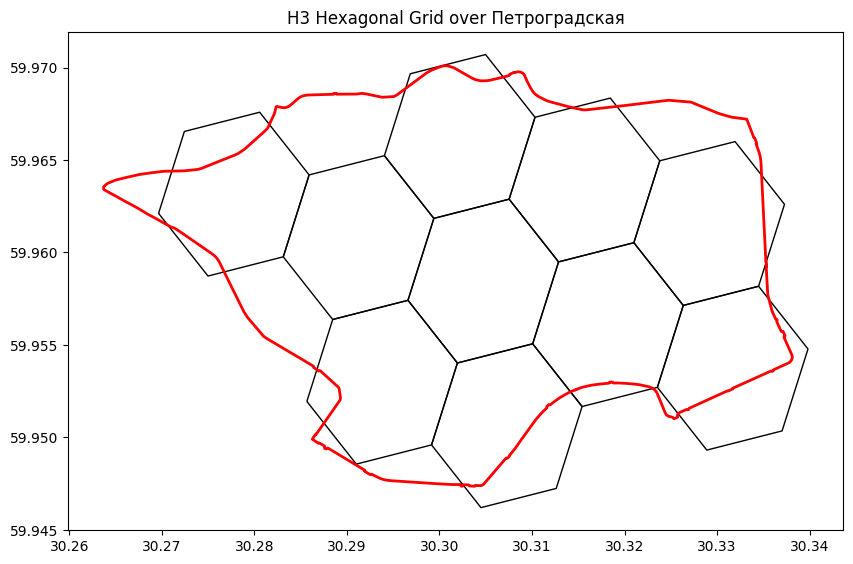

In [ ]:
spb2_gdf = ox.geocode_to_gdf("Петроградская")
spb2 = spb2_gdf.geometry.iloc[0]

geojson = mapping(spb2)

def swap_coords(geojson):
    coords = geojson['coordinates'][0]
    swapped = [(lat, lng) for lng, lat in coords]
    return {'type': 'Polygon', 'coordinates': [swapped]}

geojson_swapped = swap_coords(geojson)


resolution = 8
hex_ids = polyfill(geojson_swapped, resolution)

print(f"Number of hexagons covering Петроградская: {len(hex_ids)}")

def hex_to_polygon(h):
    boundary = h3_to_geo_boundary(h, geo_json=True)
    return Polygon(boundary)

hex_polygons = [hex_to_polygon(h) for h in hex_ids]

gdf_hex = gpd.GeoDataFrame({'h3_index': list(hex_ids)}, geometry=hex_polygons, crs='EPSG:4326')

ax = gdf_hex.plot(edgecolor='black', facecolor='none', figsize=(10,10))
spb2_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
plt.title("H3 Hexagonal Grid over Петроградская")
plt.show()


In [ ]:
grid_h = gdf_hex
grid_h = grid_h.to_crs(epsg = "32636")

In [ ]:
locations_on_grid = gpd.sjoin(loc, grid_h, how='inner', predicate='within')

# **Cultural cityscape diversity**. Hexagons as a unit of calculation

## RICHNESS

In [ ]:
richness_p = locations_on_grid.groupby('h3_index').apply(richness)
richness_df = richness_p.rename('richness').reset_index()

grid2 = grid_h.merge(
    richness_df,
    left_on='h3_index',
    right_on='h3_index',
    how='left'
)


<ipython-input-180-66a9476658a5>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  richness_p = locations_on_grid.groupby('h3_index').apply(richness)


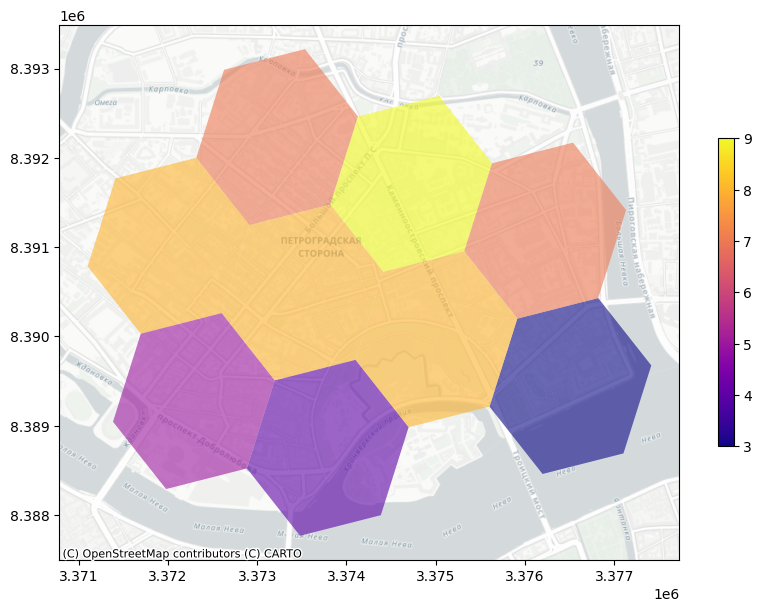

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

grid2_web_mercator = grid2.to_crs(epsg=3857)

grid2_web_mercator.plot(
    column='richness',
    cmap='plasma',
    legend=True,
    alpha=0.6,
    ax=ax,
    legend_kwds={"shrink": 0.4}
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

plt.show()


## SIMPSON DIVERSITY

In [ ]:
simpson_diversity_p = locations_on_grid.groupby('h3_index').apply(simpson_diversity)
grid3 = grid_h.merge(simpson_diversity_p.rename('simpson'), left_on='h3_index',
    right_on='h3_index', how ="left")

<ipython-input-182-d95b310bcd62>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  simpson_diversity_p = locations_on_grid.groupby('h3_index').apply(simpson_diversity)


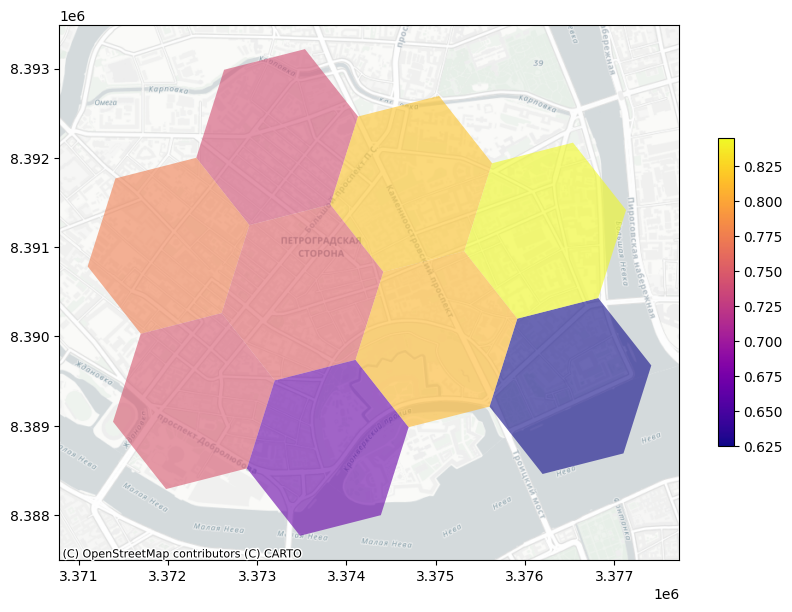

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

grid3 = grid3.to_crs(epsg=3857)

grid3.plot(
    column='simpson',
    cmap='plasma',
    legend=True,
    alpha=0.6,
    ax=ax,
    legend_kwds={"shrink": 0.4}
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

plt.show()


## Berger-Parker Abundance

In [ ]:
berger_parker_diversity = locations_on_grid.groupby('h3_index').apply(berger_parker)
grid4 = grid_h.merge(berger_parker_diversity.rename('berger_parker'), left_on='h3_index', right_index=True)

<ipython-input-184-e1373d83707e>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  berger_parker_diversity = locations_on_grid.groupby('h3_index').apply(berger_parker)


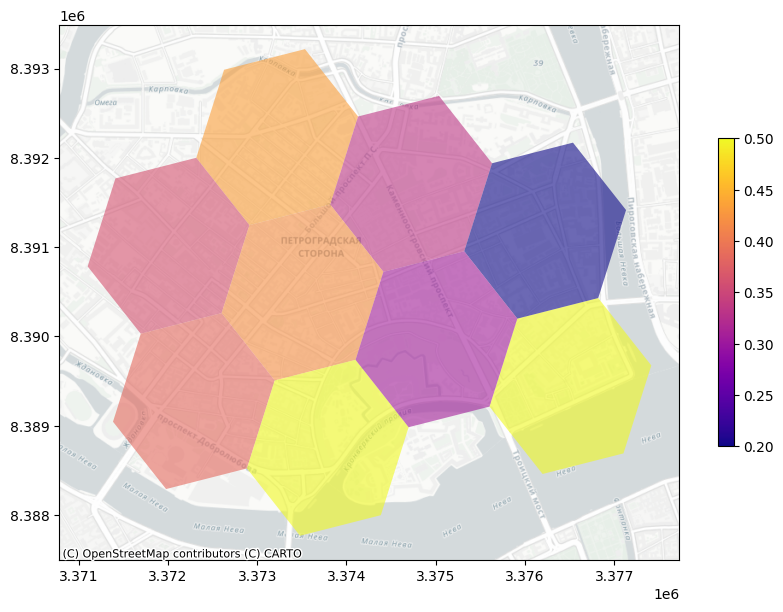

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

grid4_m= grid4.to_crs(epsg=3857)

grid4_m.plot(
    column='berger_parker',
    cmap='plasma',
    legend=True,
    alpha=0.6,
    ax=ax,
    legend_kwds={"shrink": 0.4}
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

plt.show()

This will give you a value between 0 and 1, where values closer to 1 indicate dominance by a single category

## shannon_wiener

In [ ]:
shannon_wiener_diversity_p = locations_on_grid.groupby('h3_index').apply(shannon_wiener_diversity)
grid5 = grid_h.merge(shannon_wiener_diversity_p.rename('shannon wiener'), left_on='h3_index', right_on='h3_index', how = "left")

<ipython-input-186-97ae787e794e>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon_wiener_diversity_p = locations_on_grid.groupby('h3_index').apply(shannon_wiener_diversity)


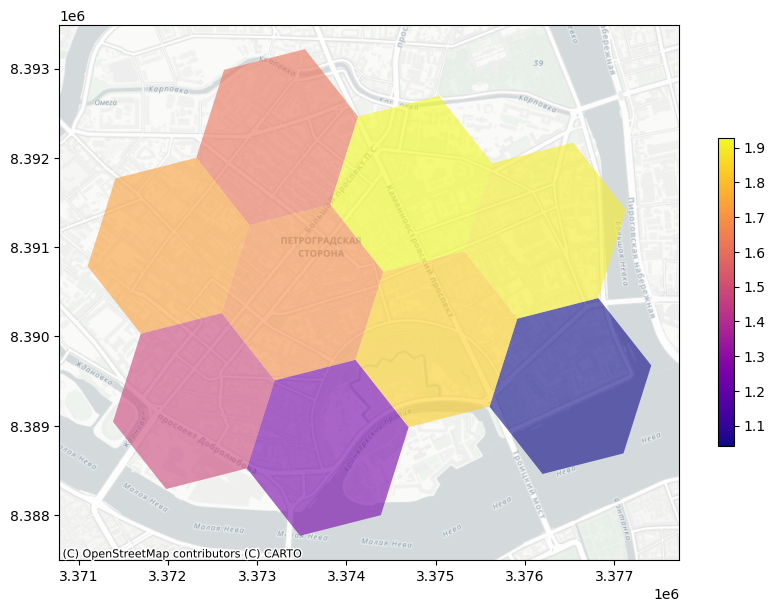

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

grid5_m= grid5.to_crs(epsg=3857)

grid5_m.plot(
    column='shannon wiener',
    cmap='plasma',
    legend=True,
    alpha=0.6,
    ax=ax,
    legend_kwds={"shrink": 0.4}
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

plt.show()

## shannon_wiener_equity

In [ ]:
shannon_wiener_equity_diversity_p = locations_on_grid.groupby('h3_index').apply(shannon_wiener_equity)
grid5 = grid_h.merge(shannon_wiener_equity_diversity_p.rename('shannon_wiener_equity'), left_on='h3_index', right_on='h3_index', how = "left")

<ipython-input-188-27b68ba9702d>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon_wiener_equity_diversity_p = locations_on_grid.groupby('h3_index').apply(shannon_wiener_equity)


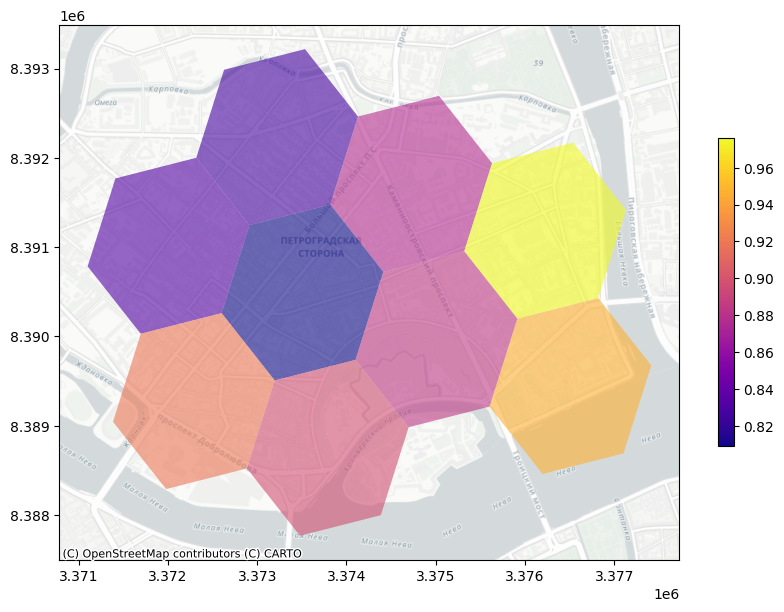

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

grid5_m= grid5.to_crs(epsg=3857)

grid5_m.plot(
    column='shannon_wiener_equity',
    cmap='plasma',
    legend=True,
    alpha=0.6,
    ax=ax,
    legend_kwds={"shrink": 0.4}
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

plt.show()

## Merging data

In [ ]:
hex_diversity = grid_h

In [ ]:
hex_diversity = hex_diversity.merge(richness_p.rename('richness'), left_on= "h3_index", right_on= "h3_index", how = "left")
hex_diversity = hex_diversity.merge(simpson_diversity_p.rename('simpson'), left_on= "h3_index", right_on= "h3_index", how = "left")
hex_diversity = hex_diversity.merge(berger_parker_diversity.rename('berger_parker'), left_on= "h3_index", right_on= "h3_index", how = "left")
hex_diversity = hex_diversity.merge(shannon_wiener_diversity_p.rename('shannon_wiener'), left_on= "h3_index", right_on= "h3_index", how = "left")
hex_diversity = hex_diversity.merge(shannon_wiener_equity_diversity_p.rename('shannon_wiener_equity'), left_on= "h3_index", right_on= "h3_index", how = "left")



hex_diversity = hex_diversity.set_geometry("geometry")

In [ ]:
hex_diversity.columns

Index(['h3_index', 'geometry', 'richness', 'simpson', 'berger_parker',
       'shannon_wiener', 'shannon_wiener_equity'],
      dtype='object')

In [ ]:
hex_diversity.to_parquet("cultural_vibrancy_hexagons.gpkg")

# **Diversity of cultural cityscape**. Buildings as a unit of calculation

### Prelimenaries

In [ ]:

place = "Петроградская, Saint Petersburg, Russia"
area = ox.geocode_to_gdf(place)


In [ ]:
area

geometry  bbox_west  bbox_south  \
0  POLYGON ((30.26368 59.96345, 30.26371 59.96342...  30.263684   59.947345   

   bbox_east  bbox_north   place_id  osm_type   osm_id        lat        lon  \
0  30.338124   59.970098  160345740  relation  1312683  59.960761  30.306623   

   class    type  place_rank  importance addresstype            name  \
0  place  suburb          19    0.398828      suburb  Petrograd Side   

                                        display_name  
0  Petrograd Side, округ Кронверкское, Saint Pete...

In [ ]:
tags = {"building": ["apartments", "residential"]}


In [ ]:
aparts = ox.features.features_from_polygon(area.geometry.iloc[0], tags=tags)


In [ ]:
aparts = aparts.to_crs(epsg=32636)

## 500 m buffer - 5 indexes

### preparation

In [ ]:
aparts["buffer1"] = aparts.buffer(500)

In [ ]:
aparts_n = aparts.set_geometry("buffer1")

In [ ]:
locations_in_buffer = gpd.sjoin(loc, aparts_n, how='inner', predicate='within')

### 1. Richness

In [ ]:
richness_pb = locations_in_buffer.groupby('geometry_right').apply(richness)
aparts_diversity_richness = aparts_n.merge(richness_pb.rename('richness'), left_on= "geometry", right_on= "geometry_right", how = "left")

<ipython-input-202-c7326396ea9d>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  richness_pb = locations_in_buffer.groupby('geometry_right').apply(richness)


In [ ]:
aparts_diversity_richness = aparts_diversity_richness.set_geometry("geometry")

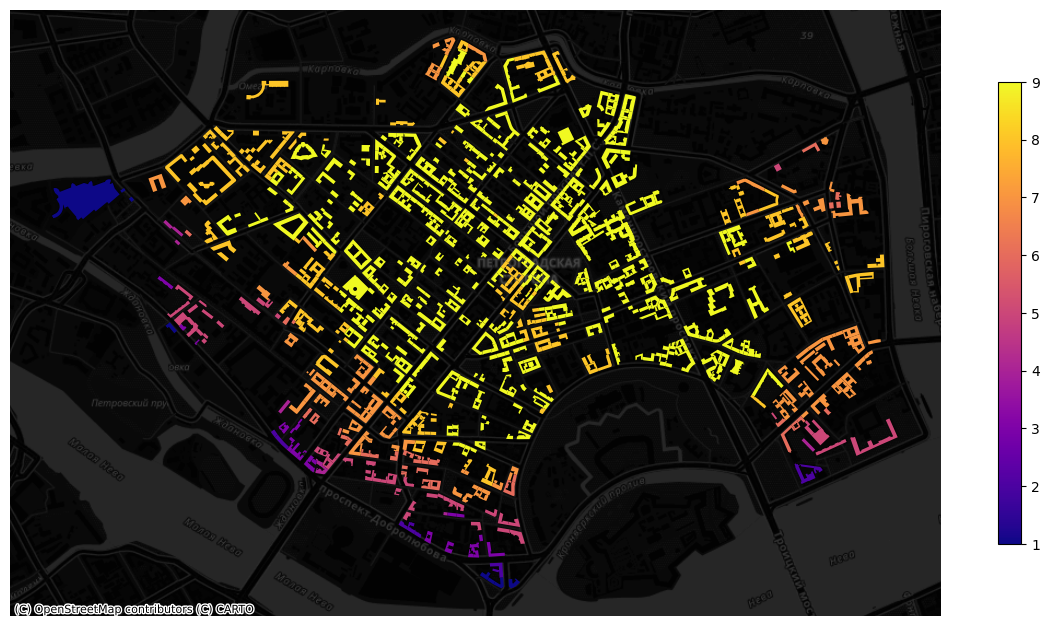

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

aparts_diversity_richness1 = aparts_diversity_richness.to_crs(epsg=3857)
aparts_diversity_richness1.plot(column='richness', cmap='plasma', legend=True, ax=ax,  legend_kwds={"shrink": 0.4})

cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

### 2. SIMPSON DIVERSITY

In [ ]:
simpson_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(simpson_diversity)
aparts_simpson_diversity = aparts_n.merge(simpson_diversity_pb.rename('simpson'), left_on= "geometry", right_on= "geometry_right", how = "left")

<ipython-input-205-136603b2a856>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  simpson_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(simpson_diversity)


In [ ]:
aparts_simpson_diversity = aparts_simpson_diversity.set_geometry("geometry")

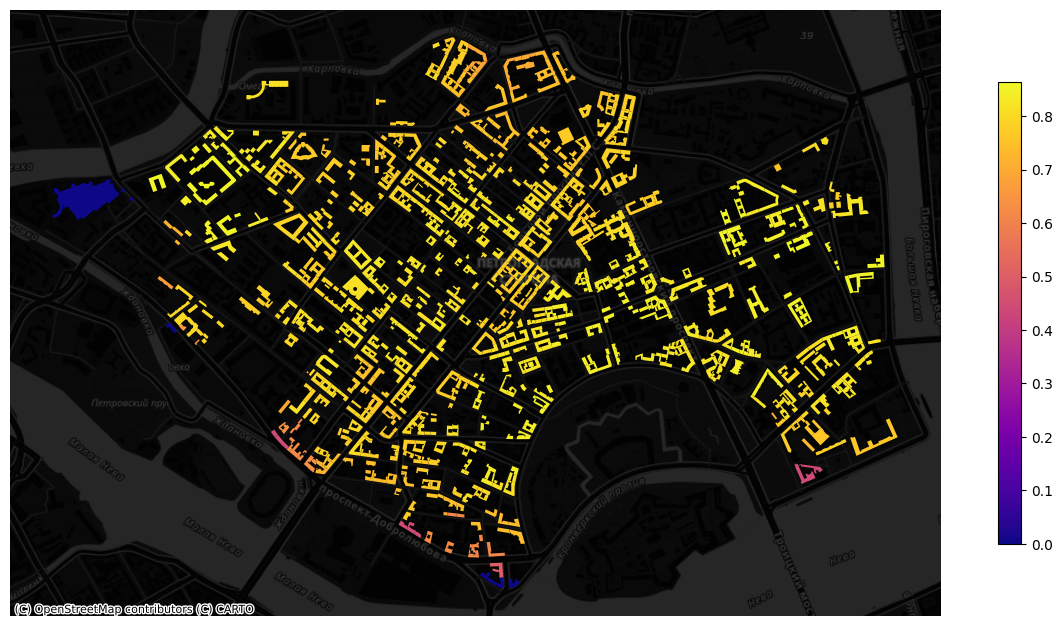

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

aparts_simpson_diversity1 = aparts_simpson_diversity.to_crs(epsg=3857)

aparts_simpson_diversity1.plot(column='simpson', cmap='plasma', legend=True, ax=ax,  legend_kwds={"shrink": 0.4})

cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

### 3. Berger-Parker Abundance

In [ ]:
berger_parker_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(berger_parker)
aparts_berger_parker_diversity = aparts_n.merge(berger_parker_diversity_pb.rename('berger_parker'), left_on= "geometry", right_on= "geometry_right", how = "left")

<ipython-input-208-4cbeb36eeed5>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  berger_parker_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(berger_parker)


In [ ]:
aparts_berger_parker_diversity = aparts_berger_parker_diversity.set_geometry("geometry")

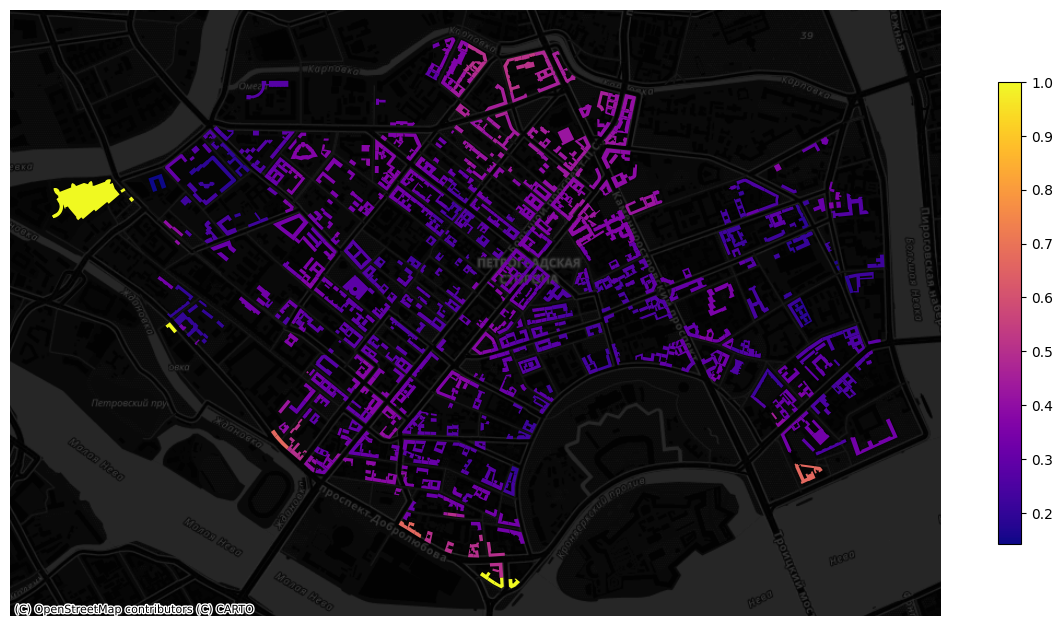

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

aparts_berger_parker_diversity1 = aparts_berger_parker_diversity.to_crs(epsg=3857)
aparts_berger_parker_diversity1.plot(column='berger_parker', cmap='plasma', legend=True, ax=ax,  legend_kwds={"shrink": 0.4})

cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

In [ ]:
aparts_berger_parker_diversity.explore(column = "berger_parker").save("aparts_berger_parker_diversity_map.html")

### 4. Shannon-Wiener equity

In [ ]:
shannon_wiener_equity_pb = locations_in_buffer.groupby('geometry_right').apply(shannon_wiener_equity)
aparts_shannon_wiener_equity = aparts_n.merge(shannon_wiener_equity_pb.rename('shannon_wiener_equity'), left_on= "geometry", right_on= "geometry_right", how = "left")

<ipython-input-212-9409462ea925>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon_wiener_equity_pb = locations_in_buffer.groupby('geometry_right').apply(shannon_wiener_equity)


In [ ]:
aparts_shannon_wiener_equity = aparts_shannon_wiener_equity.set_geometry("geometry")

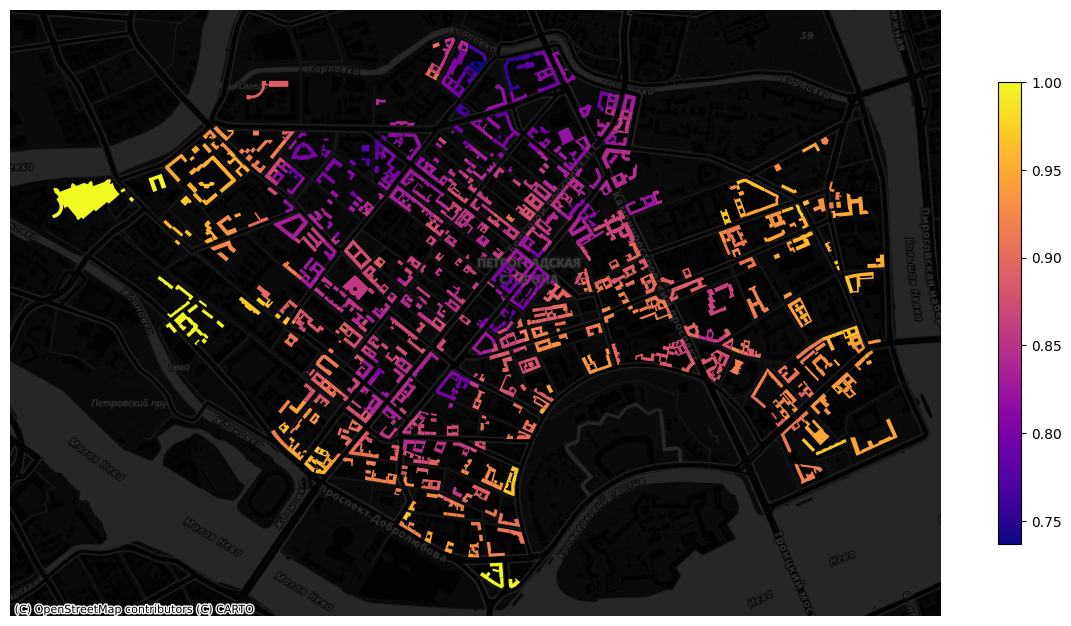

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

aparts_shannon_wiener_equity1 = aparts_shannon_wiener_equity.to_crs(epsg=3857)
aparts_shannon_wiener_equity1.plot(column='shannon_wiener_equity', cmap='plasma', legend=True, ax=ax,  legend_kwds={"shrink": 0.4})

cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

### 5. Shannon wiener

In [ ]:
shannon_wiener_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(shannon_wiener_diversity)
aparts_shannon_wiener_diversity = aparts_n.merge(shannon_wiener_diversity_pb.rename('shannon wiener'), left_on= "geometry", right_on= "geometry_right", how = "left")

<ipython-input-215-d43644a04d54>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon_wiener_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(shannon_wiener_diversity)


In [ ]:
aparts_shannon_wiener_diversity = aparts_shannon_wiener_diversity.set_geometry("geometry")

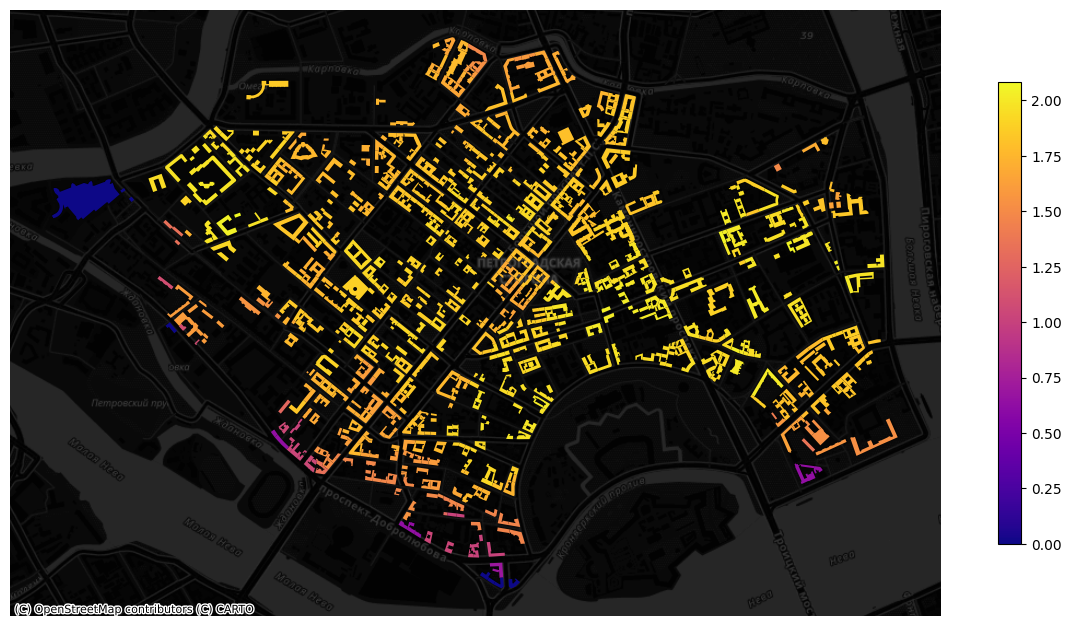

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

aparts_shannon_wiener_diversity1 = aparts_shannon_wiener_diversity.to_crs(epsg=3857)
aparts_shannon_wiener_diversity1.plot(
    column='shannon wiener',
    cmap='plasma',
    legend=True,
    ax=ax,
    legend_kwds={"shrink": 0.4}
)

cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)
ax.set_axis_off()


### Merged dataset of diversity indexes

In [ ]:
aparts_diversity = aparts_n

In [ ]:
aparts_diversity = aparts_diversity.merge(richness_pb.rename('richness'), left_on= "geometry", right_on= "geometry_right", how = "left")
aparts_diversity = aparts_diversity.merge(simpson_diversity_pb.rename('simpson'), left_on= "geometry", right_on= "geometry_right", how = "left")
aparts_diversity = aparts_diversity.merge(berger_parker_diversity_pb.rename('berger_parker'), left_on= "geometry", right_on= "geometry_right", how = "left")
aparts_diversity = aparts_diversity.merge(shannon_wiener_equity_pb.rename('shannon_wiener_equity'), left_on= "geometry", right_on= "geometry_right", how = "left")
aparts_diversity = aparts_diversity.merge(shannon_wiener_diversity_pb.rename('shannon wiener'), left_on= "geometry", right_on= "geometry_right", how = "left")



aparts_diversity = aparts_diversity.set_geometry("geometry")

In [ ]:
aparts_diversity1 = aparts_diversity[[ "geometry", "buffer1", "richness", "simpson", "berger_parker", "shannon_wiener_equity", "shannon wiener" ]]

In [ ]:
aparts_diversity1.iloc[1]

geometry                 POLYGON ((350537.5294563649 6650378.395420406,...
buffer1                  POLYGON ((350393.85815764364 6650857.309356227...
richness                                                               8.0
simpson                                                           0.848889
berger_parker                                                     0.233333
shannon_wiener_equity                                              0.95312
shannon wiener                                                    1.981957
Name: 1, dtype: object

In [ ]:
aparts_diversity1.to_parquet("cultural_vibrancy_buildings.gpkg")

Shannon-Wiener Equity (Evenness) is misleading since the richness is low



# Results Visualisation

In [ ]:
aparts_diversity2 = aparts_diversity[[ "geometry", "richness", "simpson", "berger_parker", "shannon_wiener_equity", "shannon wiener" ]]

In [ ]:
aparts_diversity2 = aparts_diversity2.dropna(axis = 0)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

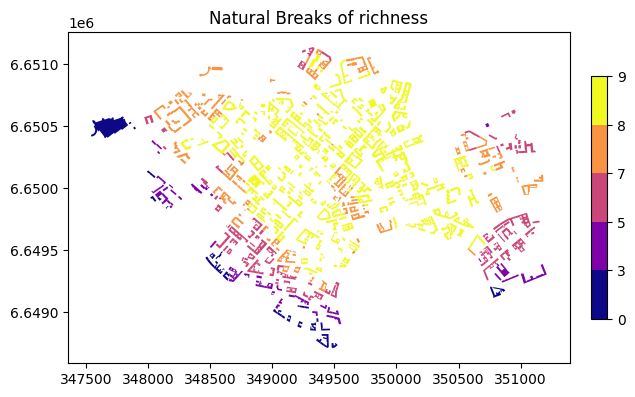

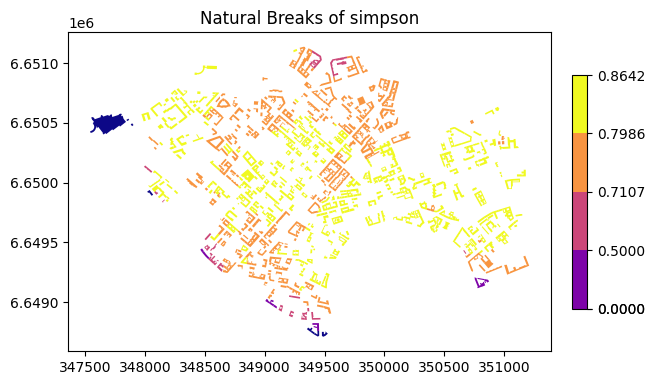

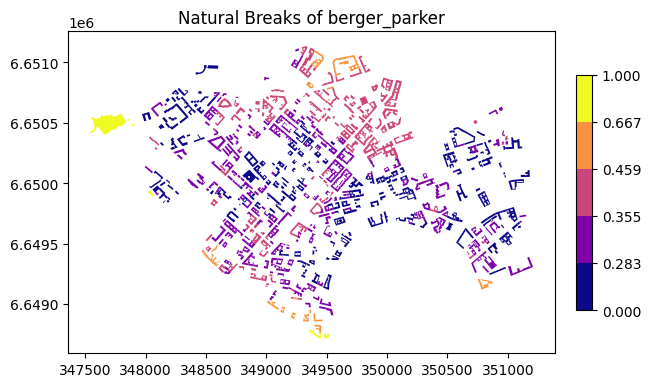

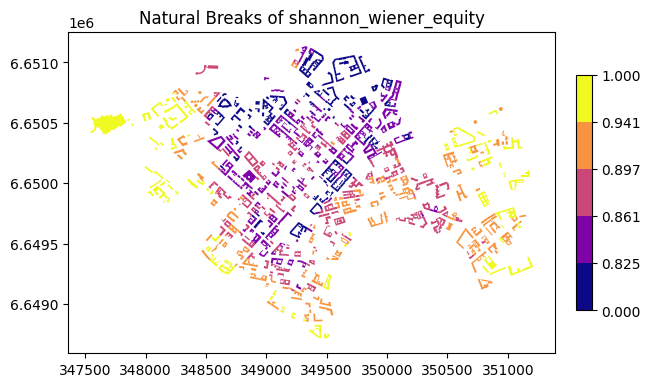

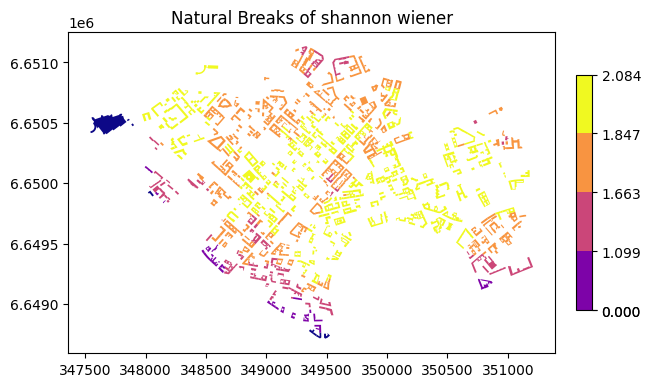

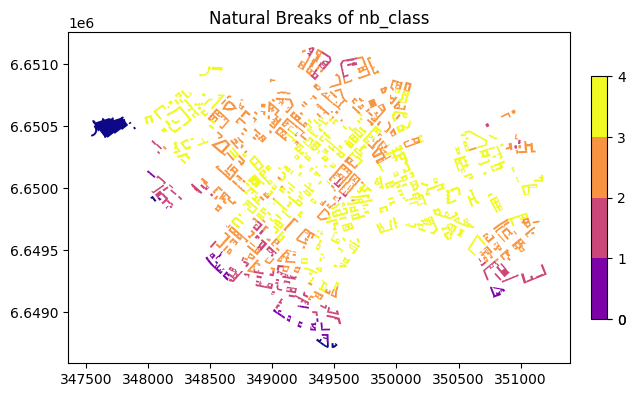

In [ ]:
for col in aparts_diversity2.select_dtypes(include='number').columns:
    plt.figure(figsize=(12, 12))


    classifier = mapclassify.NaturalBreaks(aparts_diversity2[col], k=5)
    aparts_diversity2['nb_class'] = classifier.yb

    ax = plt.subplot(1, 2, 2)


    aparts_diversity2.plot(
        column='nb_class',
        cmap='plasma',
        legend=False,
        ax=ax
    )
    plt.title(f'Natural Breaks of {col}')


    bounds = list(classifier.bins)
    bounds = [aparts_diversity2['nb_class'].min()] + bounds
    norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)


    sm = matplotlib.cm.ScalarMappable(cmap='plasma', norm=norm)
    sm.set_array([])


    cbar = plt.colorbar(
        sm,
        ax=ax,
        fraction=0.03,
        pad=0.04,
        aspect=15,
        shrink=0.5
    )


    plt.tight_layout()
    plt.savefig(f'{col} Natural Breaks.png', dpi=300, bbox_inches='tight')
plt.show()

# Descriptive stats

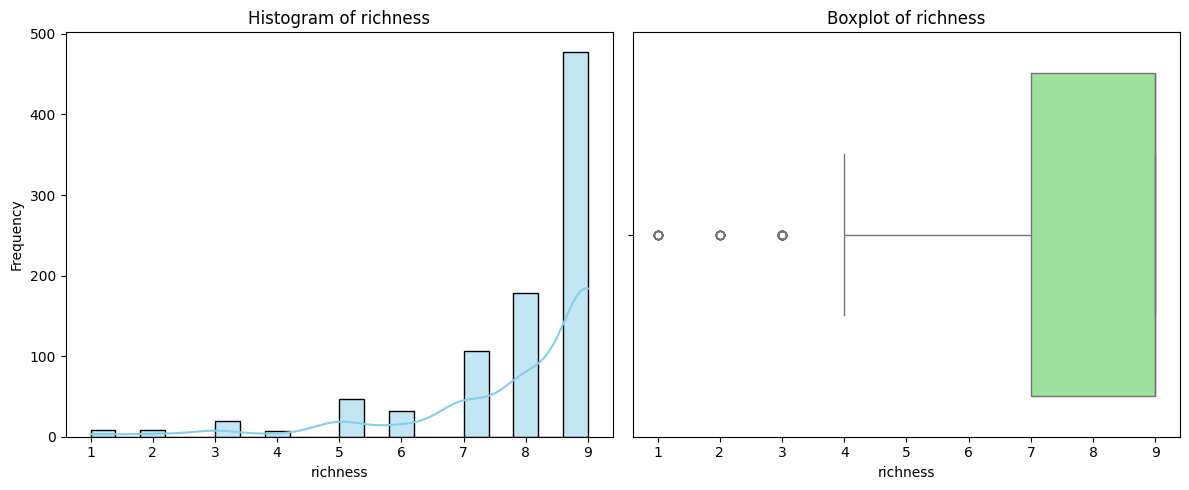

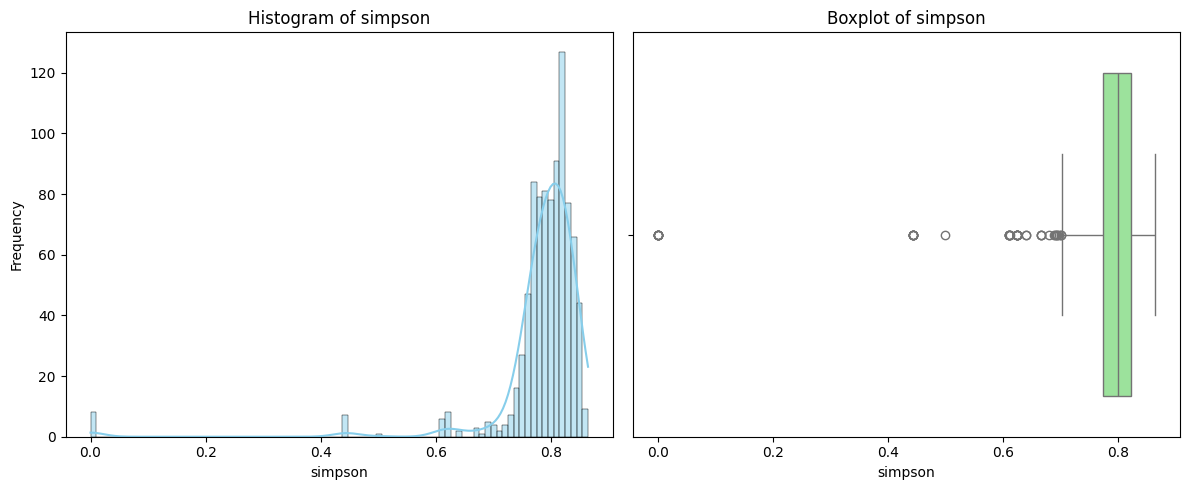

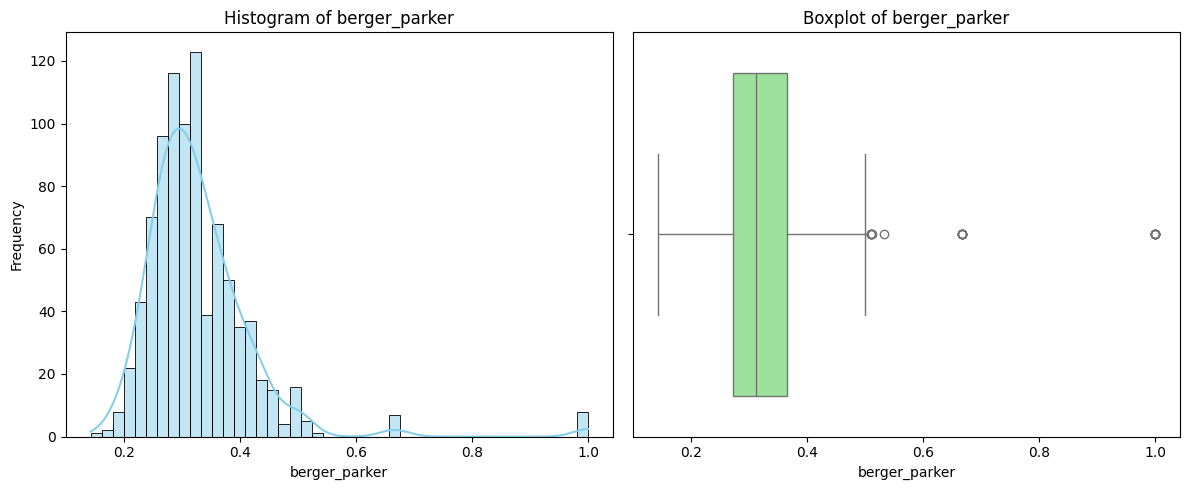

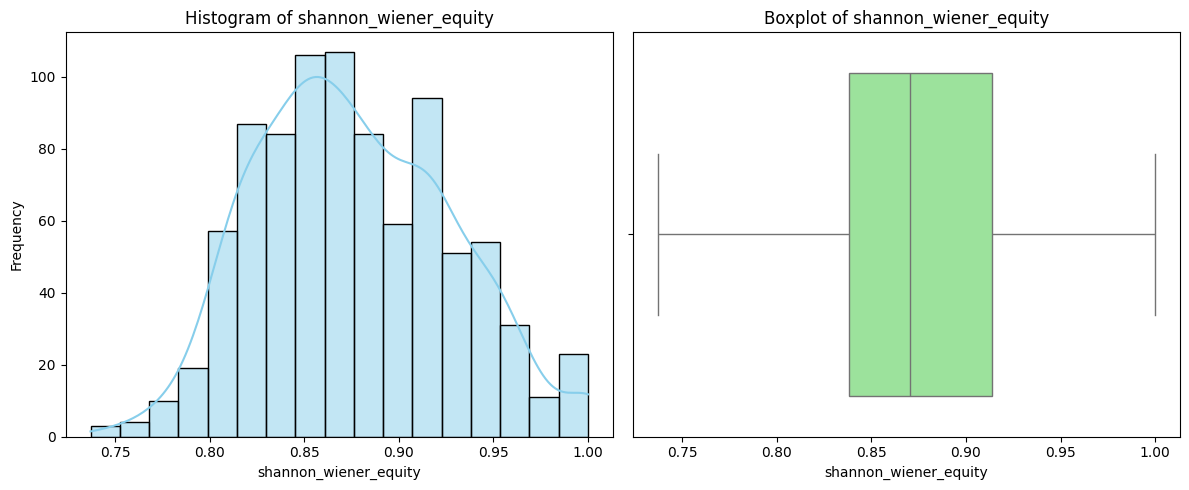

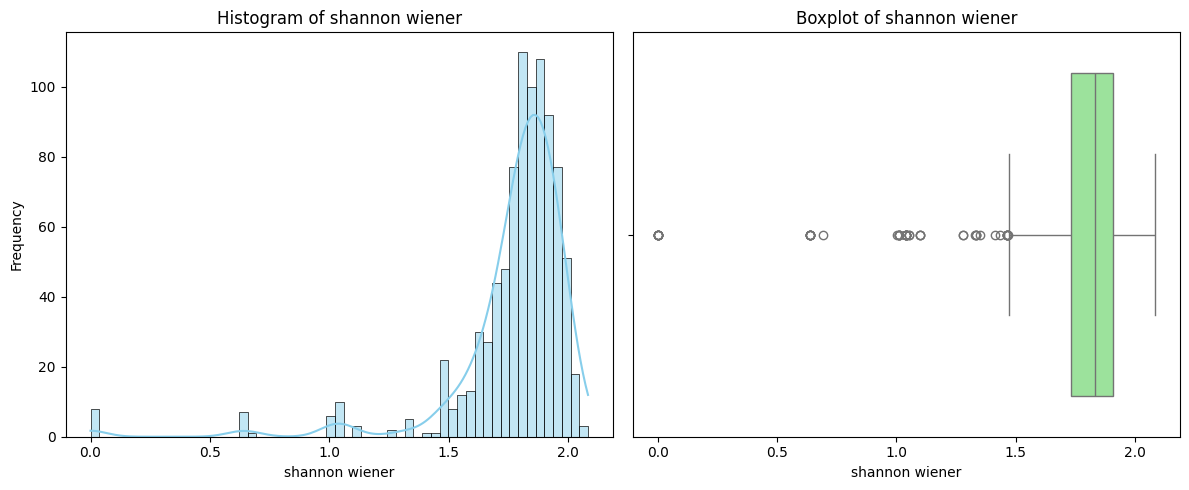

In [ ]:
for col in aparts_diversity.select_dtypes(include='number').columns:
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    sns.histplot(aparts_diversity[col], kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')


    plt.subplot(1, 2, 2)
    sns.boxplot(x=aparts_diversity[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()

    plt.savefig(f'{col}descriptive statistics.png', dpi=300, bbox_inches='tight')

    plt.show()

